# HW-aware Synthesis of MCX

This tutorial consists of two parts,
1. How to create a 10-CONTROL MCX gate with Classiq
2. Classiq's Hardware-Aware Synthesis capability

<!--This tutorial demonstrates Classiq's Hardware-Aware Synthesis capability. In this example we will implement and synthesize a simple MCX (Multiple Control-X) circuit with two different HW-aware configuration settings using Classiq's synthesis engine.-->


<!--The two different fictitious hardware created here demonstrates how to insert your own custom-designed machine. For comparison, we create two types of hardware with `cx, u` basis gates. The difference between them manifests in the connectivity map: one has grid connectivity while the other has star connectivity.-->

<!--The two fictitious hardware created are using two different simulators, Classiq's Simulator and IonQ's Simulator. We will compare the depth of the circuit and we will optimise the number of cnot gates as they cause more errors and are very expensive. At the end of the tutorial we will also see the depth of both the circuits created.-->


## 1. How to create a 10-CONTROL MCX gate with Classiq

To create an MCX gate with 10 control qubits using Classiq, we will first define a quantum function called `my_mcx`, whose arguments are an array of qubits (of any size) to be used as control, and a single qubit argument to be used as the target.

In [1]:
# importing all the necessary libraries from classiq

from math import pi

from classiq import *

In [2]:
# define MCX quantum function


@qfunc
def my_mcx(ctrl: QArray, target: QBit) -> None:
    control(ctrl, lambda: X(target))

Then, to create an MCX gate with 10 control qubits we will create a quantum main function that will simply execute our `my_mcx` function with 10 qubits allocated to the control argument.

In [3]:
# define the MCX parameters within the quantum 'main' function


@qfunc
def main(ctrl: Output[QArray], target: Output[QBit]) -> None:
    allocate(10, ctrl)
    allocate(target)
    my_mcx(ctrl, target)


write_qmod(main, "mcx_10_ctrl_depth")

To constrain a circuit to only 20 qubits and optimize for circuit depth, we pass the max width and optimization parameter to a `Constraints` object and synthesize our model

In [4]:
constraints = Constraints(
    max_width=20, optimization_parameter=OptimizationParameter.DEPTH
)

qprog = synthesize(main, constraints=constraints)
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/2zPK3TpkS0eRRCMdQcTvnYbsLCn


Additionally, To get the transpiled circuit from our qprog object and print its depth:

In [5]:
print(f"Synthesized MCX depth is {qprog.transpiled_circuit.depth}")

Synthesized MCX depth is 52


gio: https://platform.classiq.io/circuit/2zPK3TpkS0eRRCMdQcTvnYbsLCn?login=True&version=0.85.0: Operation not supported


# 2. Classiq's Hardware-Aware Synthesis capability

In the above section we have seen how to create a MCX circuit, add constraints to it and optimize its depth in Classiq. In this section we will check the hardware-aware synthesis capability of Classiq. In this example we will implement and synthesize a simple MCX (Multiple Control-X) circuit with two different HW-aware configuration settings using Classiq's synthesis engine.

The two different fictitious hardware created here demonstrates how to insert your own custom-designed machine. For comparison, we create two types of hardware with `cx, u` basis gates. The difference between them manifests in the connectivity map: one has grid connectivity while the other has star connectivity.

The two fictitious hardware created are using two different simulators: Classiq's Simulator and IonQ's Simulator. We will compare the depth of the circuit and we will optimise the number of cnot gates as it is important in quantum computation because they cause more errors and are very expensive.


In [6]:
# define MCX quantum function


@qfunc
def my_mcx(ctrl: QArray, target: QBit) -> None:
    control(ctrl, lambda: X(target))

In [7]:
# define the MCX parameters within the quantum 'main' function


@qfunc
def main(ctrl: Output[QArray], target: Output[QBit]) -> None:
    allocate(12, ctrl)
    allocate(target)
    my_mcx(ctrl, target)


write_qmod(main, "hardware_aware_mcx_grid")

In [8]:
# define the hardware parameters
max_width = 18

# Grid Connectivity
grid_connectivity = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [4, 5],  # Row 1
    [6, 7],
    [7, 8],
    [8, 9],
    [9, 10],
    [10, 11],  # Row 2
    [12, 13],
    [13, 14],
    [14, 15],
    [15, 16],
    [16, 17],  # Row 3
    [0, 6],
    [6, 12],  # Column 1
    [1, 7],
    [7, 13],  # Column 2
    [2, 8],
    [8, 14],  # Column 3
    [3, 9],
    [9, 15],  # Column 4
    [4, 10],
    [10, 16],  # Column 5
    [5, 11],
    [11, 17],  # Column 6
]

# Star Connectivity
star_connectivity = [[0, i] for i in range(1, max_width - 1)]

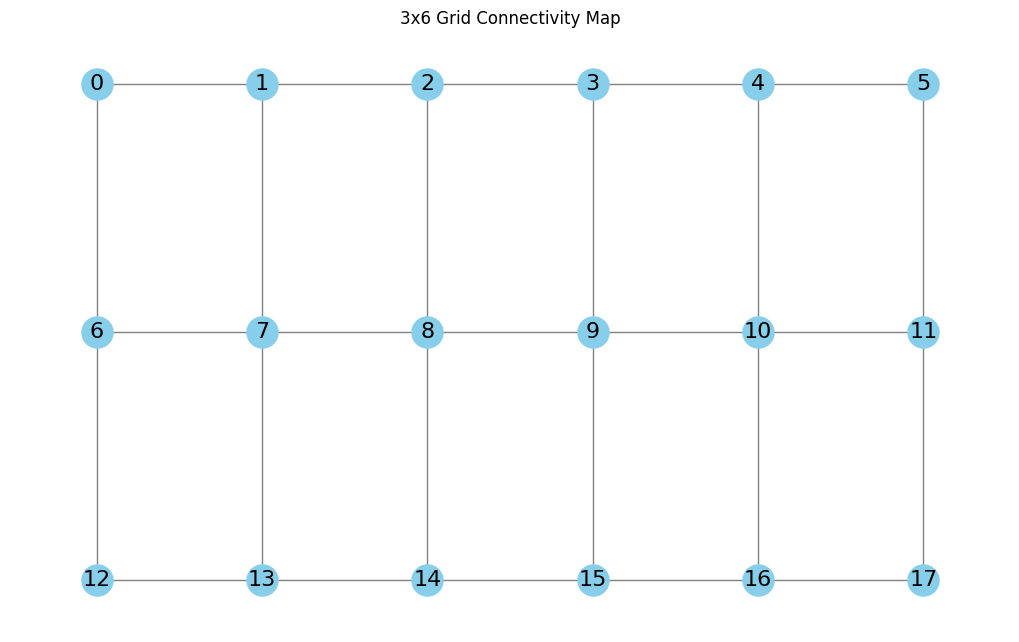

In [9]:
# Plotting Grid Connectivity
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
G.add_edges_from(grid_connectivity)

# Define the positions of the nodes in a 3x6 grid
pos = {}
for i in range(3):
    for j in range(6):
        pos[i * 6 + j] = (j, -i)  # (x, y) coordinates

# Plot the graph
plt.figure(figsize=(10, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="skyblue",
    font_size=16,
    font_color="black",
    edge_color="gray",
)
plt.title("3x6 Grid Connectivity Map")
plt.show()

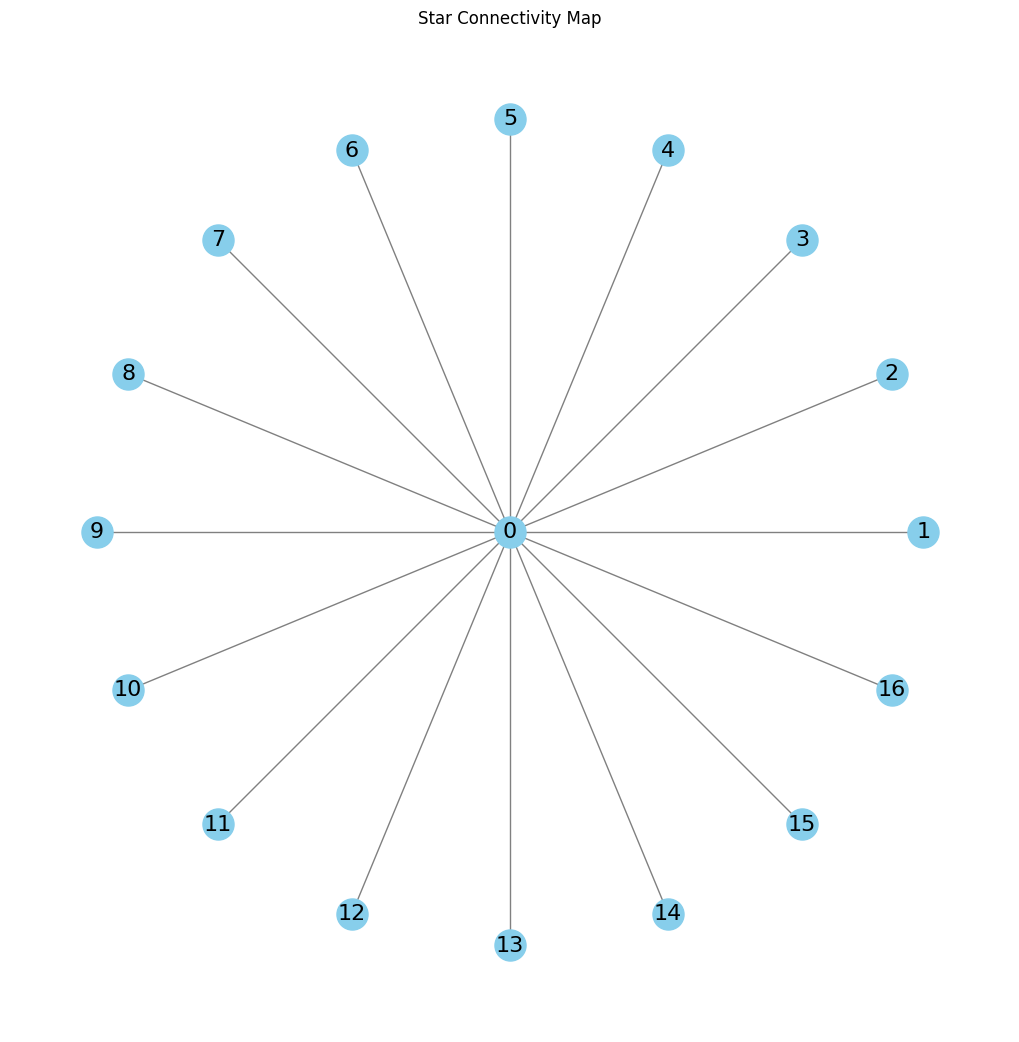

In [10]:
# plotting Star Connectivity
import numpy as np

G = nx.Graph()
G.add_edges_from(star_connectivity)

# Define the positions of the nodes in a star configuration
pos = {}
pos[0] = (0, 0)  # Central node
angle_step = 360 / (len(star_connectivity))
for i in range(1, 18):
    angle = angle_step * (i - 1)
    radians = np.deg2rad(angle)
    pos[i] = (np.cos(radians), np.sin(radians))

# Plot the graph
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color="skyblue",
    font_size=16,
    font_color="black",
    edge_color="gray",
)
plt.title("Star Connectivity Map")
plt.show()

In [11]:
# Grid Preferences
preferences_grid = Preferences(
    custom_hardware_settings=CustomHardwareSettings(
        basis_gates=["cx", "u"],
        connectivity_map=grid_connectivity,
    ),
    random_seed=-1,
)


# Star Preferences
preferences_star = Preferences(
    custom_hardware_settings=CustomHardwareSettings(
        basis_gates=["cx", "u"],
        connectivity_map=star_connectivity,
    ),
    random_seed=-1,
)

In [12]:
# define synthesis engine constraints
constraints = Constraints(optimization_parameter="cx", max_width=max_width)

In [ ]:
qprog_grid = synthesize(main, constraints=constraints, preferences=preferences_grid)
show(qprog_grid)

Quantum program link: https://platform.classiq.io/circuit/2zPK69fnSjBi4wpG3bPXY8nwJQh


gio: https://platform.classiq.io/circuit/2zPK69fnSjBi4wpG3bPXY8nwJQh?login=True&version=0.85.0: Operation not supported


In [ ]:
print(
    f"Synthesized MCX cx-count for grid connectivity is {qprog_grid.transpiled_circuit.count_ops['cx']}"
)
qprog_grid.show()

Synthesized MCX cx-count for grid connectivity is 117
Quantum program link: https://platform.classiq.io/circuit/2zPK6BrqqZom9nFdpVGmKZd7h1J


gio: https://platform.classiq.io/circuit/2zPK6BrqqZom9nFdpVGmKZd7h1J?login=True&version=0.85.0: Operation not supported


In [15]:
qprog_star = synthesize(main, constraints=constraints, preferences=preferences_star)
show(qprog_star)
write_qmod(main, "hardware_aware_mcx_star")

Quantum program link: https://platform.classiq.io/circuit/2zPK73O9LG5HgN80mdJZrTuXGi5


gio: https://platform.classiq.io/circuit/2zPK73O9LG5HgN80mdJZrTuXGi5?login=True&version=0.85.0: Operation not supported


In [16]:
print(
    f"Synthesized MCX cx-count for star connectivity is {qprog.transpiled_circuit.count_ops['cx']}"
)
qprog.show()

Synthesized MCX cx-count for star connectivity is 54
Quantum program link: https://platform.classiq.io/circuit/2zPK79Rg6EYpy5CLNg9WCl1M1jW


gio: https://platform.classiq.io/circuit/2zPK79Rg6EYpy5CLNg9WCl1M1jW?login=True&version=0.85.0: Operation not supported


In [17]:
print(f"Synthesized Depth for grid connectivity is {qprog.transpiled_circuit.depth}")

Synthesized Depth for grid connectivity is 52


In [18]:
print(f"Synthesized Depth for star connectivity is {qprog.transpiled_circuit.depth}")

Synthesized Depth for star connectivity is 52


**Conclusion:** Given the connectivity of the hardware and its preferences the engince optimizes the constraints of the model. In this case the constraits were `max_width` which is the maximum number of qubits it can use and the number of `cx gates`. Our main aim is to minimize the number of cx gates.

With `Star Connectivity` the minimum number of cx gates required after transpiling the circuit is just 114 and depth of the circuit turned out to be 191.

Whereas with `Grid Connectivity`  the minimum number of cx gates required after transpiling the circuit is 117 and depth of the circuit is 82.

Looking at the both the cases we can come to a conclusion that star connectivity is more favourable to synthesize and execute a `mcx circuit`.

